In [1]:
from pathlib import Path
import glob
import exiftool
import suncalc
import soundfile as sf
import re

In [2]:
import numpy as np
import pandas as pd
from celluloid import Camera
import dask.dataframe as dd

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from cfg import get_config

In [5]:
SEATTLE_LATITUDE = 47.655181
SEATTLE_LONGITUDE = -122.293123

In [6]:
site_locs = {'E18 Bridge':[180, 620],
            'Carp Pond':[600, 1160],
            'Central Pond':[1140, 1060],
            'Foliage':[1600, 900],
            'Telephone Field':[1450, 220]}

In [7]:
nightly = pd.DataFrame()
sites = ["Telephone Field", 'Foliage', 'Central Pond'] #, 'Carp Pond', 'E18 Bridge']
for site in sites:

    cfg = dict()
    cfg["site"] = site
    cfg["recording_start"] = '02:00'
    cfg["recording_end"] = '14:00'
    cfg['resample_min'] = 1
    cfg['show_PST'] = False
    cfg['selection_of_dates'] = 'recover-20230711'

    # activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg, cfg, '', save=False)
    new_df = dd.read_csv(f"../output_dir/{cfg['selection_of_dates']}/{cfg['site']}/bd2__*.csv", assume_missing=True).compute()

    new_df['start_time'] = new_df['start_time'].astype('float64')
    new_df['end_time'] = new_df['end_time'].astype('float64')
    new_df['low_freq'] = new_df['low_freq'].astype('float64')
    new_df['high_freq'] = new_df['high_freq'].astype('float64')
    file_dts = pd.to_datetime(new_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)
    anchor_start_times = file_dts + pd.to_timedelta(new_df['start_time'], unit='S')
    anchor_end_times = file_dts + pd.to_timedelta(new_df['end_time'], unit='S')

    new_df.insert(0, 'call_end_time', anchor_end_times)
    new_df.insert(0, 'call_start_time', anchor_start_times)
    new_df.insert(0, 'ref_time', anchor_start_times)

    new_df = new_df.set_index('ref_time')
    dets_per_block = new_df['start_time'].resample(f"{cfg['resample_min']}min").count().between_time(cfg['recording_start'], cfg['recording_end'], inclusive='left')
    dets_per_block.index = dets_per_block.index

    nightly[site] = dets_per_block


In [8]:
single_night = nightly.loc[(nightly.index>=dt.datetime(2023,7,7))&(nightly.index<dt.datetime(2023,7,8))]
single_night

,Telephone Field,Foliage,Central Pond
ref_time,,,
2023-07-07 02:00:00,0,0.0,0.0
2023-07-07 02:01:00,0,0.0,0.0
2023-07-07 02:02:00,0,0.0,0.0
2023-07-07 02:03:00,0,0.0,0.0
2023-07-07 02:04:00,0,0.0,0.0
...,...,...,...
2023-07-07 13:55:00,0,0.0,0.0
2023-07-07 13:56:00,0,0.0,0.0
2023-07-07 13:57:00,0,0.0,0.0


In [9]:
single_night.index = single_night.index.tz_localize('UTC')
single_night.index = (pd.DatetimeIndex(single_night.index).tz_convert(tz='US/Pacific'))
single_night

,Telephone Field,Foliage,Central Pond
ref_time,,,
2023-07-06 19:00:00-07:00,0,0.0,0.0
2023-07-06 19:01:00-07:00,0,0.0,0.0
2023-07-06 19:02:00-07:00,0,0.0,0.0
2023-07-06 19:03:00-07:00,0,0.0,0.0
2023-07-06 19:04:00-07:00,0,0.0,0.0
...,...,...,...
2023-07-07 06:55:00-07:00,0,0.0,0.0
2023-07-07 06:56:00-07:00,0,0.0,0.0
2023-07-07 06:57:00-07:00,0,0.0,0.0


20230706_night_activity_1min_res


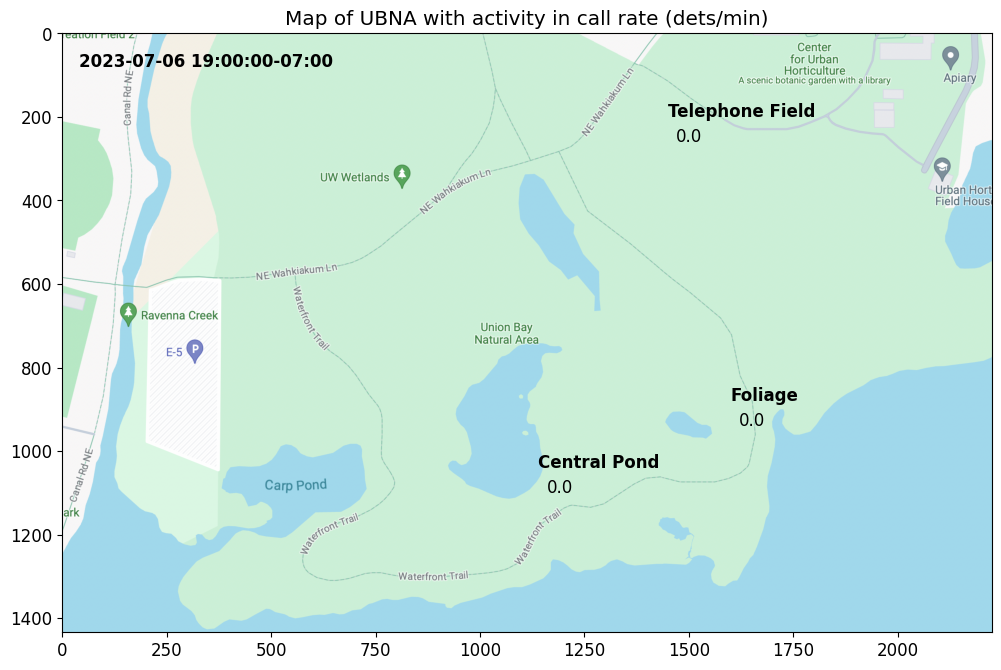

MovieWriter PillowWriter unavailable; using Pillow instead.


In [10]:
plot_title = f'{single_night.index[0].strftime("%Y%m%d")}_night_activity_1min_res'
print(plot_title)

# create figure object
fig = plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size':12})
# load axis box
ax = plt.axes()

camera = Camera(fig)
for date, site_calls in single_night.iterrows():
    img = plt.imread("../../Desktop/UBNA.jpg")
    ax.set_title('Map of UBNA with activity in call rate (dets/min)')
    ax.imshow(img)
    for site in sites:
        if not(np.isnan(site_calls[site])):
            ax.scatter(x=site_locs[site][0],y=site_locs[site][-1],s=site_calls[site]/10,facecolor='yellowgreen', edgecolor='k')
            ax.text(x=site_locs[site][0],y=site_locs[site][-1]-20,s=site,fontweight='bold')
            ax.text(x=site_locs[site][0]+20,y=site_locs[site][-1]+40,s=f'{((site_calls[site]))/cfg["resample_min"]}')
        else:
            ax.scatter(x=site_locs[site][0],y=site_locs[site][-1],s=10,facecolor='red', edgecolor='k')
            ax.text(x=site_locs[site][0],y=site_locs[site][-1]-20,s=site,fontweight='bold')
            ax.text(x=site_locs[site][0]+20,y=site_locs[site][-1]+40,s=f'no dets')
    
    ax.text(x=40,y=80,s=date,fontweight='bold')

    plt.pause(0.1)
    camera.snap()

animation = camera.animate()
animation.save(f'{plot_title}.gif', writer='PillowWriter', fps=2)